In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"#"2"

In [2]:
# import estimator class
from estimators.rnnEstimator import RnnEstimator
from estimators.kalmanEstimator import KalmanEstimator

#import rewarder class
from rewarders.thresholdRewarder import ThresholdRewarder

from matplotlib import pyplot
from utils.sequences_treatment import *
from utils.agent_treatment import *

# import functions from Keras for the RNN
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, SimpleRNN#, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packag

In [3]:
# Set parameters
estimatorType='kalman' # kalman or rnn
seeAction=True
seeMeasurement=False
seeEstimate=False
T=12

In [4]:
if estimatorType=='rnn':
    # construct and train a Sequential RNN model with keras
    numberSamples_trainRNN=1000
    T_trainRNN=T
    generatorType='random01'

    # generate sequences for training
    (objectives_trainRNN,measurements_trainRNN)=generateSequence(T_trainRNN,numberSamples=numberSamples_trainRNN,generatorType=generatorType)
    sigmas_trainRNN=randomSigma(T_trainRNN,numberSamples=numberSamples_trainRNN,p0=0.3)
    measurements_corrupted_trainRNN=corruptSequence_outOfRange(measurements_trainRNN,sigmas_trainRNN)

    n_dim_meas=np.shape(measurements_corrupted_trainRNN)[2]
    n_dim_obj=np.shape(objectives_trainRNN)[2]

    model=Sequential()
    model.add(LSTM(20,input_shape=(None,n_dim_meas),return_sequences=True))
    model.add(LSTM(20,return_sequences=True))
    model.add(Dense(n_dim_obj,activation=None))

    model.compile(optimizer='adam',loss='mean_squared_error')
    model.summary()

    # train the RNN
    history=model.fit(x=measurements_corrupted_trainRNN,y=objectives_trainRNN,batch_size=1,epochs=5,validation_split=0.2,verbose=2)

    # plot loss
    plotRNNresults(history)
print('Done')

Done


In [5]:
if estimatorType=='rnn':
    idx_sample=0
    estimates_trainRNN=model.predict(measurements_corrupted_trainRNN[idx_sample:(idx_sample+1),:,:])
    plotErrors(objectives_trainRNN, estimates_trainRNN, sigmas_trainRNN,idx_sample=idx_sample)
print('Done')

Done


In [6]:
# construct estimator
if estimatorType=='rnn':
    estimator=RnnEstimator(model,generatorType,seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate)
elif estimatorType=='kalman':
    estimator=KalmanEstimator(seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate)
else:
    print('ERROR: no valid estimatorType')
    
estimator.summarize()

# contruct rewarder
rewarder=ThresholdRewarder(threshold=2, cost=5000, windowSize=4)
rewarder.summarize()

Kalman estimator
observationsDimensions: [(5,)]
seeAction= True
seeMeasurement= False
seeEstimate= False
seeCovariance= False
threshold rewarder
window size: 4
threshold: 2
cost: 5000
number of measures in the window: 0


In [7]:
# generate sequences for training the agent
numberSamples_trainAgent=100
T_trainAgent=T

(objectives_trainAgent,measurements_trainAgent)=estimator.generateSequence(T_trainAgent,numberSamples=numberSamples_trainAgent)

print('shape objectives:',np.shape(objectives_trainAgent))
print('shape measurements:',np.shape(measurements_trainAgent))

shape objectives: (100, 12, 1)
shape measurements: (100, 12, 1)


In [8]:
# construct agent
agent=constructAgent(estimator,rewarder,objectives_trainAgent,measurements_trainAgent)
print('Agent constructed')

Environment parameters
  REWARDER= <rewarders.thresholdRewarder.ThresholdRewarder object at 0xb409340b8>
  inputDimensions= [(5,)]
Sequences parameters
  outOfRangeValue= -1
  numerSamples= 100
  n_dim_obj= 1
  n_dim_meas= 1
Instructions for updating:
Colocations handled automatically by placer.
Agent constructed


In [9]:
# Train agent
agent.run(n_epochs=4, epoch_length=numberSamples_trainAgent*T_trainAgent)
print('Agent Trained')

Instructions for updating:
Use tf.cast instead.
Average (on the epoch) training loss: 1831.802490234375
Episode average V value: -0.23917202651500702
Average (on the epoch) training loss: 1875.841064453125
Episode average V value: -0.7815003879368305
Average (on the epoch) training loss: 1643.508544921875
Episode average V value: -3.920539140701294
Average (on the epoch) training loss: 1542.9713134765625
Episode average V value: -14.316889683405558
Average (on the epoch) training loss: 1511.7269287109375
Episode average V value: -41.46965789794922
Average (on the epoch) training loss: 1456.4505615234375
Episode average V value: -100.91005290638317
Average (on the epoch) training loss: 1385.4736328125
Episode average V value: -230.0790252685547
Average (on the epoch) training loss: 1322.6778564453125
Episode average V value: -339.5011393229167
Average (on the epoch) training loss: 1273.10205078125
Episode average V value: -605.7660522460938
Average (on the epoch) training loss: 1213.518

Average (on the epoch) training loss: 917.1838989257812
Episode average V value: -1253.8096211751301
Average (on the epoch) training loss: 917.1896362304688
Episode average V value: -1512.5428744229403
Average (on the epoch) training loss: 917.7141723632812
Episode average V value: -692.22021484375
Average (on the epoch) training loss: 917.367919921875
Episode average V value: -780.5860315958658
Average (on the epoch) training loss: 918.1734008789062
Episode average V value: -1359.1072998046875
Average (on the epoch) training loss: 917.464599609375
Episode average V value: -1028.5008036295574
Average (on the epoch) training loss: 918.0779418945312
Episode average V value: -1237.3875732421875
Average (on the epoch) training loss: 918.1605224609375
Episode average V value: -1013.8475341796875
Average (on the epoch) training loss: 917.573486328125
Episode average V value: -1375.995361328125
Average (on the epoch) training loss: 917.4520263671875
Episode average V value: -1327.92431640625


In [10]:
# generate test data
numberSamples_test=10
T_test=T
(objectives_test,measurements_test)=estimator.generateSequence(T_test,numberSamples=numberSamples_test)

# Results of the inference on test data
(sigmas_test,rewards_test,estimates_test)=agentInference(agent,objectives_test,measurements_test)

Average (on the epoch) training loss: 831.9815673828125
Episode average V value: -1453.56005859375
Average (on the epoch) training loss: 846.2500610351562
Episode average V value: -1345.9720458984375
Average (on the epoch) training loss: 865.177978515625
Episode average V value: -1453.6956787109375
Average (on the epoch) training loss: 856.0276489257812
Episode average V value: -1421.59326171875
Average (on the epoch) training loss: 859.7017211914062
Episode average V value: -1432.21337890625
Average (on the epoch) training loss: 860.0498046875
Episode average V value: -1508.3480224609375
Average (on the epoch) training loss: 854.1070556640625
Episode average V value: -1415.4415283203125
Average (on the epoch) training loss: 850.5165405273438
Episode average V value: -1464.9527587890625
Average (on the epoch) training loss: 845.943115234375
Episode average V value: -1393.9989013671875
Average (on the epoch) training loss: 852.2882080078125
Episode average V value: -1522.88134765625


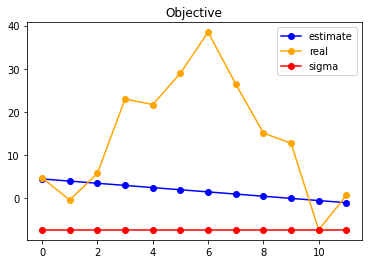

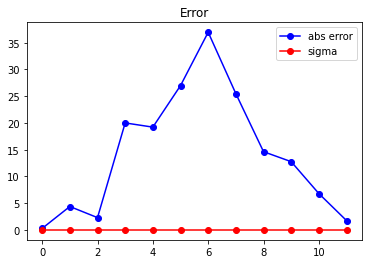

In [11]:
idx_sample=0
plotErrors(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)

In [12]:
agent._tmp_dataset.__dict__

{'_batch_dimensions': [(5,)],
 '_max_history_size': 5,
 '_size': 1000000,
 '_use_priority': False,
 '_only_full_history': True,
 '_actions': <deer.agent.CircularBuffer at 0xb45d5e128>,
 '_rewards': <deer.agent.CircularBuffer at 0xb43a8ac88>,
 '_terminals': <deer.agent.CircularBuffer at 0xb459ad5c0>,
 '_observations': array([<deer.agent.CircularBuffer object at 0xb45da9c50>], dtype=object),
 '_random_state': RandomState(MT19937) at 0xB4094F150,
 'n_elems': 120,
 'sticky_action': 1}